In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Transformada de Fourier en 2D
Podemos interpretar los cambios de intensidad de la imagen como funciones sobre un plano

![SNOWFALL](SingleHarmonic.gif)

![SNOWFALL](fourier.png)

In [3]:
# Leemos ambas imagenes
img_low_freq = cv.imread('fft_hf.jpg', cv.IMREAD_GRAYSCALE)
img_hig_freq = cv.imread('fft_lf.jpg', cv.IMREAD_GRAYSCALE)
# Aplico la transformada
img_fft_low = np.fft.fft2(img_low_freq)
img_fft_hig = np.fft.fft2(img_hig_freq)
# llevo la baja frec al origen para acomodar la visualizacion
img_fft_low = np.fft.fftshift(img_fft_low)
img_fft_hig = np.fft.fftshift(img_fft_hig)
# obtengo el modulo
img_fft_low = 20*np.log(np.abs(img_fft_low))
img_fft_hig = 20*np.log(np.abs(img_fft_hig))
# Tomamos un "perfil" de una fila por cada imagen
low_freq_sg = img_low_freq[50,10:60]
hig_freq_sg = img_hig_freq[50,10:60]

Graficamos los resultados

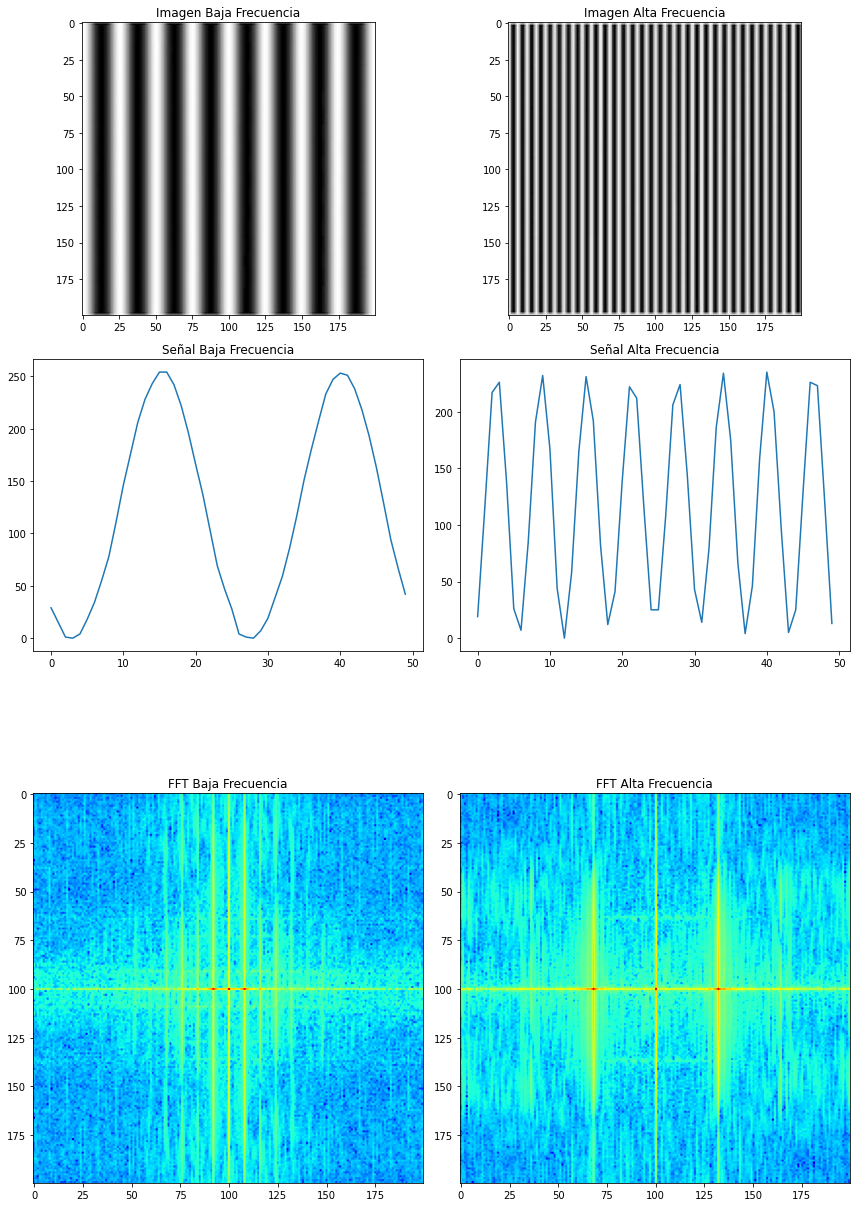

In [4]:
# Crear figura con tamaño personalizado
plt.figure(figsize=(12, 18))

# Definir la rejilla de subtramas con 'gridspec'
gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 2])  # Ajustamos la altura de las filas

# Primera fila de imágenes
plt.subplot(gs[0, 0])
plt.imshow(img_low_freq, cmap='gray')
plt.title('Imagen Baja Frecuencia')

plt.subplot(gs[0, 1])
plt.imshow(img_hig_freq, cmap='gray')
plt.title('Imagen Alta Frecuencia')

# Segunda fila de gráficos de líneas
plt.subplot(gs[1, 0])
plt.plot(low_freq_sg)
plt.title('Señal Baja Frecuencia')

plt.subplot(gs[1, 1])
plt.plot(hig_freq_sg)
plt.title('Señal Alta Frecuencia')

# Tercera fila de imágenes FFT (con mayor tamaño)
plt.subplot(gs[2, 0])
plt.imshow(img_fft_low, cmap='jet')
plt.title('FFT Baja Frecuencia')

plt.subplot(gs[2, 1])
plt.imshow(img_fft_hig, cmap='jet')
plt.title('FFT Alta Frecuencia')

# Mostrar la figura
plt.tight_layout()
plt.show()

## Filtros en el dominio espectral

In [16]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))

  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv.bitwise_not(lp_filter)

In [17]:
# leo la imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
# obtengo el modulo de la transformada de fourier
mod = fft2_mod(img)

In [18]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

### Definimos los filtros en el dominio espectral

In [19]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

### Aplicamos los filtros a la imagen

In [20]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter
hp_filtered = shifted_fft * hp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))
f_ishift = np.fft.ifftshift(hp_filtered)
img_hp = np.real(np.fft.ifft2(f_ishift))

### Graficamos los resultados

In [21]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')
plt.subplot(1,2,2)
plt.title('Pasa altos - Realce de bordes')
plt.imshow(img_hp, cmap='gray')

In [10]:
def create_gauss_filter(h, w, k_size=5, sigma=5):
        
    # Genero el kernel gaussiano
    kernel = np.zeros((h, w))
    
    kernel_1d = cv.getGaussianKernel(k_size, sigma)
    kernel_2d = kernel_1d * kernel_1d.T
    
    h_ini = (h-k_size)//2
    w_ini = (w-k_size)//2
    
    kernel[h_ini:h_ini+k_size,w_ini:w_ini+k_size] = kernel_2d
   
    # Obtengo la transformada de Fourier
    kernel_tf = np.fft.fft2(kernel)
    
    return kernel, kernel_tf 

In [23]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel") 
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

In [24]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

Text(0.5, 1.0, 'Desenfoque gausiano')